In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Union, Optional

import pandas as pd
import numpy as np
from scipy.stats import spearmanr, kendalltau

import pandas as pd
import numpy as np
from pathlib import Path

import pyciemss.visuals.plots as plots
from pyciemss.utils import get_tspan
from pyciemss.utils.interface_utils import convert_to_output_format

from pyciemss.visuals import plots


In [3]:
# Load cached data...
tspan = get_tspan(1, 50, 500).detach().numpy()

root = Path("..")/"test"/"data/"
prior_samples = convert_to_output_format(plots.tensor_load(root/"prior_samples.json"), 
                                         tspan, time_unit="years")
observed_trajectory = convert_to_output_format(plots.tensor_load(root/"observed_trajectory.json"), 
                                               tspan, time_unit="years")

observed_points = (observed_trajectory
    .rename(columns={"Rabbits_sol": "Rabbits Samples"})
    .drop(columns=["Wolves_sol", "alpha_param", "beta_param", "delta_param", "gamma_param"])
    .iloc[::10]
)


In [4]:
def trajectory_chaos(trajectories: pd.DataFrame, *, method:callable=kendalltau):
    """Consecutive points comparison"""
    def order(g):
        labels = g.reset_index(level=1).apply(lambda r: f"{r['trajectory']}_{r['sample_id']}", axis="columns")
        ordered_labels = g.assign(label=labels.values).sort_values("value")["label"].values
        return ordered_labels
    
    trajectories = trajectories.melt(ignore_index=False, var_name="trajectory")
    orders = trajectories.groupby(level=0).apply(order)
    dists = [method(a,b) for a, b in zip(orders.values, orders.values[1:])]
    dists = pd.DataFrame(dists, index=orders.index[:-1])
    return dists

samples = plots.nice_df(prior_samples)[["Rabbits_sol", "Wolves_sol"]]
rslt = trajectory_chaos(samples)

<Axes: xlabel='timepoint'>

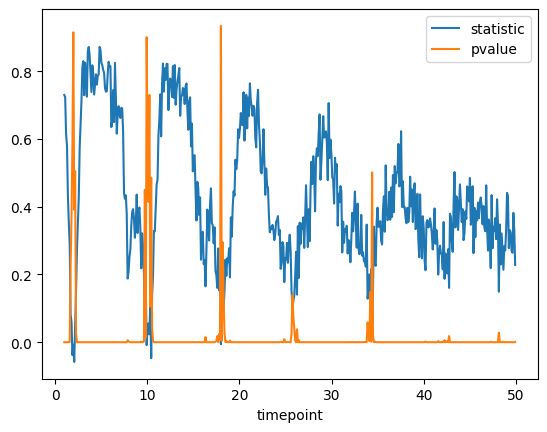

In [18]:
rslt.plot.line()

,timepoint,statistic
0,1.000000,0.729697
1,1.098196,0.723636
2,1.196393,0.614545
3,1.294589,0.581818
4,1.392786,0.433131
...,...,...
494,49.509018,0.269495
495,49.607216,0.263838
496,49.705410,0.381818
497,49.803608,0.330909


In [26]:
schema = plots.lineplot(rslt["statistic"])
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema)

,timepoint,statistic,pvalue
0,1.000000,0.729697,5.495445e-27
1,1.098196,0.723636,1.442833e-26
2,1.196393,0.614545,1.311325e-19
3,1.294589,0.581818,9.739964e-18
4,1.392786,0.433131,1.713052e-10
...,...,...,...
494,49.509018,0.269495,7.103036e-05
495,49.607216,0.263838,1.004839e-04
496,49.705410,0.381818,1.816353e-08
497,49.803608,0.330909,1.070826e-06


In [ ]:
def trajectory_chaos(trajectories: pd.DataFrame, *, method:callable=kendalltau):
    """All-pairs comparison"""
    def order(g):
        labels = g.reset_index(level=1).apply(lambda r: f"{r['trajectory']}_{r['sample_id']}", axis="columns")
        ordered_labels = g.assign(label=labels.values).sort_values("value")["label"].values
        return ordered_labels
    
    trajectories = trajectories.melt(ignore_index=False, var_name="trajectory")
    orders = trajectories.groupby(level=0).apply(order)
    dists = [method(a,b) for a, b in zip(orders.values, orders.values[1:])]
    dists = pd.DataFrame(dists, index=orders.index[:-1])
    return dists

In [112]:
rslt.statistic.mean()

0.42965365073581513

<Axes: xlabel='timepoint'>

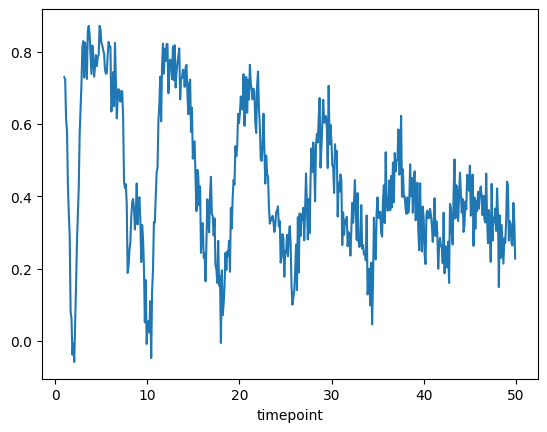

In [105]:
rslt.statistic.plot()

In [111]:
schema = plots.trajectories(prior_samples, subset=".*_sol")
plots.ipy_display(schema)